In [38]:
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import (Dense, Dropout, Conv1D, MaxPooling1D, 
                                       BatchNormalization, GlobalAveragePooling1D)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.regularizers import l2
import matplotlib.pyplot as plt

## Data Preparation ##

The dataset consists of audio recordings of various bird species. The metadata, including the species name and geographical coordinates, is stored in a CSV file called information.csv. The audio files are organized into folders by their respective classes.

In [2]:
metadata=pd.read_csv("information.csv")
metadata=metadata.sample(len(metadata))

In [3]:
metadata.head()

,filename,country,name,lat,lng,fold
635,796761.mp3,Belgium,Greater White-fronted Goose,51.2950,3.1150,4
1194,207216.mp3,Finland,Mallard,61.8648,28.8960,6
1121,495820.mp3,Russian Federation,Mallard,56.0840,47.2571,6
783,513297.mp3,Netherlands,Greater White-fronted Goose,53.3491,6.3081,4
895,706507.mp3,Ireland,Whooper Swan,52.1853,-6.4000,5


## Checking for Duplicates and Missing Values ##


In [100]:
print(metadata.duplicated().sum())
print(metadata.isna().sum())

0
filename     0
country      0
name         0
lat         19
lng         19
fold         0
dtype: int64


## Audio Augmentation ##


To enhance the dataset, the following audio augmentation techniques are applied:

Time Stretching

Pitch Shifting

Adding Noise

Random Cropping

Volume Change

In [6]:
def time_stretching(audio):
    return librosa.effects.time_stretch(audio,rate=1.2)

def pitch_shift(audio, sample_rate, n_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sample_rate, n_steps=n_steps)

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented = audio + noise_factor * noise
    return augmented

def random_crop(audio, crop_size):
    start = np.random.randint(0, len(audio) - crop_size)
    return audio[start:start + crop_size]

def change_volume(audio, factor=1.5):
    return audio * factor

def augment_audio(audio, sample_rate):
    augmented_samples = []
    
    # Original audio
    augmented_samples.append(audio)
    
    # Time stretching
    augmented_samples.append(time_stretching(audio))
    
    # Pitch shifting
    augmented_samples.append(pitch_shift(audio, sample_rate, n_steps=2))
    
    # Adding noise
    augmented_samples.append(add_noise(audio))
    
    # Random cropping (1 second crop)
    crop_size = int(sample_rate * 1)
    augmented_samples.append(random_crop(audio, crop_size))
    
    # Volume change
    augmented_samples.append(change_volume(audio, factor=1.5))
    
    return augmented_samples

## Feature Extraction
 ##

Features are extracted from the audio using the librosa library, including:

MFCCs

Spectral Centroid

Spectral Bandwidth

Chroma Features

Tonnetz

In [7]:
def features_extractor(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        
        # Augment audio
        augmented_audios = augment_audio(audio, sample_rate)

        features_list = []
        for augmented_audio in augmented_audios:
            # Extract features for each augmented audio
            mfccs = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=40)
            mfccs_delta = librosa.feature.delta(mfccs)
            mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
            spectral_centroid = librosa.feature.spectral_centroid(y=augmented_audio, sr=sample_rate)
            spectral_rolloff = librosa.feature.spectral_rolloff(y=augmented_audio, sr=sample_rate, roll_percent=0.85)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=augmented_audio, sr=sample_rate)
            spectral_contrast = librosa.feature.spectral_contrast(y=augmented_audio, sr=sample_rate)
            chroma = librosa.feature.chroma_stft(y=augmented_audio, sr=sample_rate)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y=augmented_audio)
            tonnetz = librosa.feature.tonnetz(y=augmented_audio, sr=sample_rate)

            # Aggregate features (mean along time axis)
            features = np.concatenate([
                np.mean(mfccs.T, axis=0),
                np.mean(mfccs_delta.T, axis=0),
                np.mean(mfccs_delta2.T, axis=0),
                np.mean(spectral_centroid.T, axis=0),
                np.mean(spectral_rolloff.T, axis=0),
                np.mean(spectral_bandwidth.T, axis=0),
                np.mean(spectral_contrast.T, axis=0),
                np.mean(chroma.T, axis=0),
                np.mean(zero_crossing_rate.T, axis=0),
                np.mean(tonnetz.T, axis=0)
            ])
            
            # Normalize the features
            features = (features - np.mean(features)) / (np.std(features) + 1e-7)
            features_list.append(features)
        
        return features_list  # Return all features from augmentations

    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return None

In [8]:
def process_file(row):
    file_name = os.path.join("sample" + str(row['fold']) + '/', str(row["filename"]))
    final_class_labels = row['name']
    
    # Extract features for the file
    features = features_extractor(file_name)
    
    if features is not None:
        return [[feature, final_class_labels] for feature in features]
    return []

In [9]:
def process_metadata(metadata, max_workers=3):
    extracted_features = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Use tqdm for progress visualization
        results = list(tqdm(executor.map(process_file, [row for index_num, row in metadata.iterrows()]),
                            total=metadata.shape[0], desc="Processing Files"))

    # Flatten the list of results and filter out empty lists
    extracted_features = [item for sublist in results for item in sublist if sublist]

    return extracted_features

In [10]:
# extracted_features = process_metadata(metadata)

## Data Preprocessing  ## 

In [11]:
extracted_features=pd.read_pickle("new_extracted_features.pkl")

In [12]:
if len(extracted_features) > 0:
    extracted_features_df = pd.DataFrame(extracted_features, columns=['Features', 'Class'])
    extracted_features_df = extracted_features_df.sample(frac=1, random_state=42).reset_index(drop=True)
else:
    print("No features extracted. Please check the feature extraction process.")

In [13]:
# extracted_features_df.to_csv('new_extracted_features.csv')
# extracted_features_df.to_pickle('new_extracted_features.pkl')

In [14]:
x = np.array(extracted_features_df['Features'].tolist())

if not all(len(x[0]) == len(i) for i in x):
    print("Warning: Feature vectors have inconsistent lengths. Padding to fix.")

    max_len = max([len(i) for i in x])
    x_padded = pad_sequences(x, maxlen=max_len, padding='post', dtype='float32')

else:
    x_padded = x 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(extracted_features_df['Class'].tolist())

In [15]:
# classes=extracted_features['Class'].unique()
# label_encoder.fit(classes)

In [16]:
# with open("label_encoder_classes.txt", "w") as f:
#     for class_name in label_encoder.classes_:
#         f.write(f"{class_name}\n")

In [17]:
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'Barnacle Goose': 0, 'Brant Goose': 1, 'Common Pheasant': 2, 'Common Scoter': 3, 'Eurasian Teal': 4, 'Greater White-fronted Goose': 5, 'Greylag Goose': 6, 'Mallard': 7, 'Tufted Duck': 8, 'Whooper Swan': 9}


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.25, random_state=42)

In [19]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [20]:
x_train_scaled = np.expand_dims(x_train_scaled, axis=-1)
x_test_scaled = np.expand_dims(x_test_scaled, axis=-1)

## Model Development
 ##

The model is built using the Keras API with the following architecture:

Convolutional layers

Max pooling layers

Dropout layers

Dense output layer

In [48]:
model = Sequential()

# Conv1D Layer 1
model.add(Conv1D(filters=448, kernel_size=3, activation='relu', input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Conv1D Layer 2
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Conv1D Layer 3
model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Global Average Pooling
model.add(GlobalAveragePooling1D())

# Dense and Dropout Layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.02)))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\vaibh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(x_train_scaled, y_train, 
                    validation_data=(x_test_scaled, y_test),
                    batch_size=32, 
                    epochs=100, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.1257 - loss: 4.4831 - val_accuracy: 0.0988 - val_loss: 2.8937 - learning_rate: 0.0010
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2814 - loss: 2.1653 - val_accuracy: 0.1371 - val_loss: 2.9328 - learning_rate: 0.0010
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.4007 - loss: 1.9008 - val_accuracy: 0.3360 - val_loss: 2.0176 - learning_rate: 0.0010
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.4483 - loss: 1.7778 - val_accuracy: 0.3544 - val_loss: 1.9958 - learning_rate: 0.0010
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4758 - loss: 1.7171 - val_accuracy: 0.4144 - val_loss: 1.8973 - learning_rate: 0.0010
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.4890 - loss: 1.6671 - val_accuracy: 0.4608 - val_loss: 1.7743 - learning_rate: 0.0010
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.4958

In [50]:
test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7635 - loss: 0.8423
Test Loss: 0.8658754229545593, Test Accuracy: 0.7574241161346436


## Model Evaluation ##

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve,accuracy_score

In [52]:
y_pred_classes = np.argmax(model.predict(x_test_scaled), axis=-1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


### Confusion Matrix ###

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

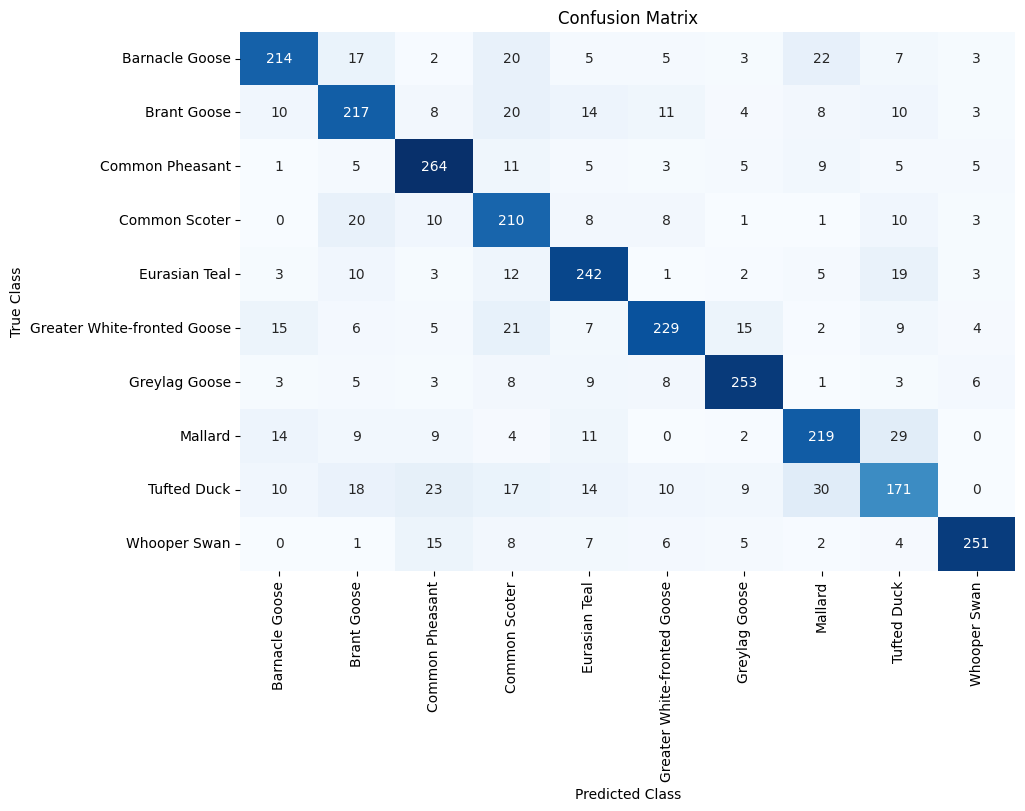

In [54]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

### Classification Report ###

In [55]:
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

class_report_df = pd.DataFrame(class_report).transpose()

class_report_df['accuracy'] = np.append(per_class_accuracy, [None, None, None])

class_report_df = class_report_df[:-3]

print(class_report_df)

                             precision    recall  f1-score  support  accuracy
Barnacle Goose                0.792593  0.718121  0.753521    298.0  0.718121
Brant Goose                   0.704545  0.711475  0.707993    305.0  0.711475
Common Pheasant               0.771930  0.843450  0.806107    313.0   0.84345
Common Scoter                 0.634441  0.774908  0.697674    271.0  0.774908
Eurasian Teal                 0.751553  0.806667  0.778135    300.0  0.806667
Greater White-fronted Goose   0.814947  0.731629  0.771044    313.0  0.731629
Greylag Goose                 0.846154  0.846154  0.846154    299.0  0.846154
Mallard                       0.732441  0.737374  0.734899    297.0  0.737374
Tufted Duck                   0.640449  0.566225  0.601054    302.0  0.566225
Whooper Swan                  0.902878  0.839465  0.870017    299.0  0.839465


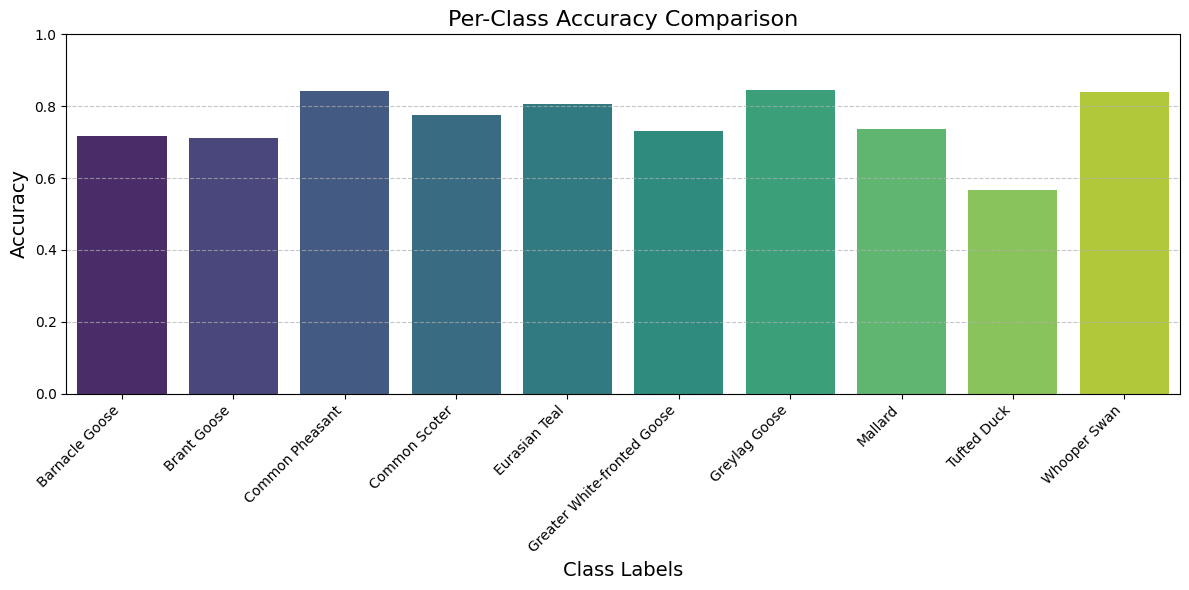

In [56]:
plt.figure(figsize=(12, 6))
sns.barplot(x=class_report_df.index, y='accuracy', data=class_report_df, palette='viridis',hue=class_report_df.index)
plt.xticks(rotation=45, ha='right')
plt.title('Per-Class Accuracy Comparison', fontsize=16)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limits to show accuracy percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

### Training and Validation Loss/Accuracy Plot
###

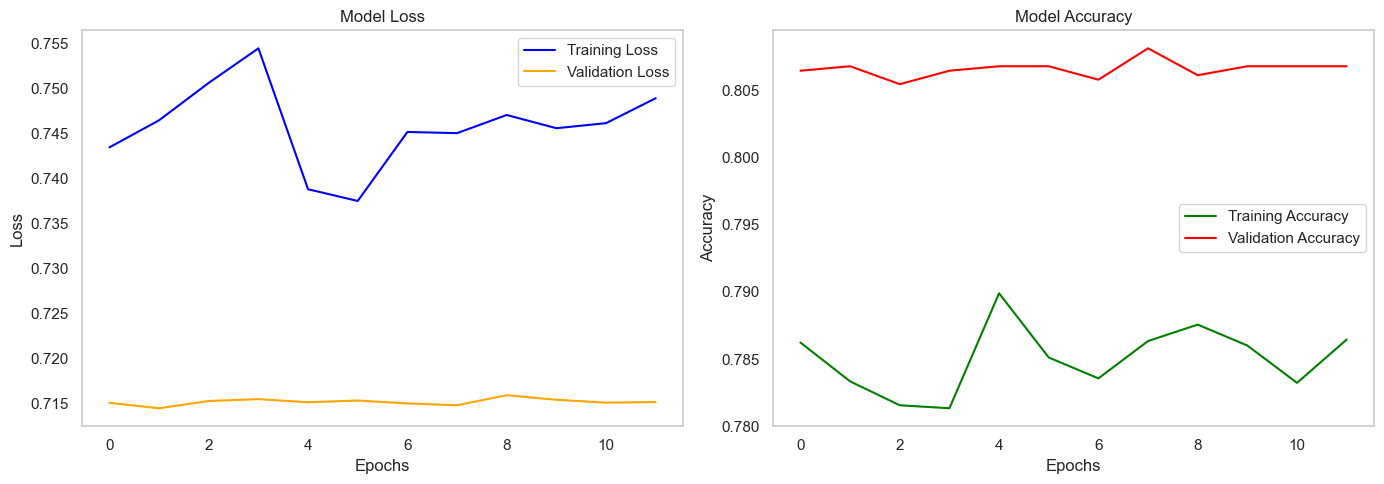

In [132]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Geospatial Analysis ##

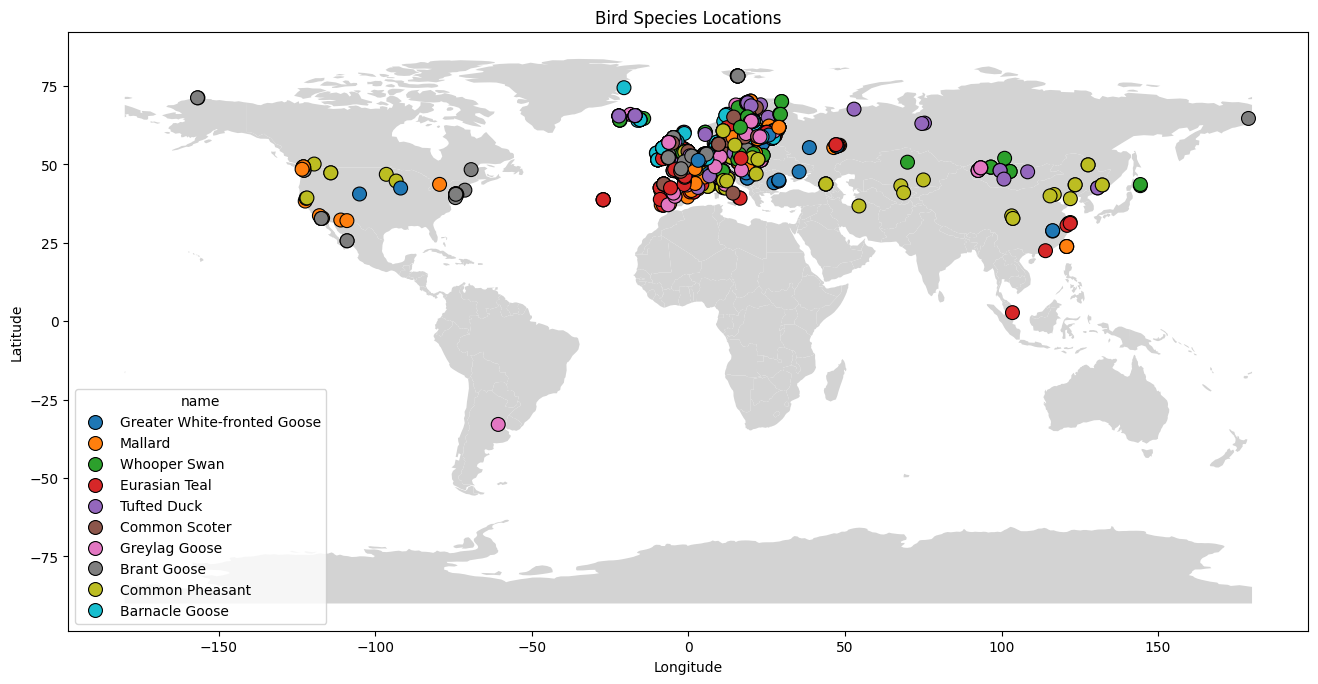

In [85]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(metadata['lng'], metadata['lat'])]
geo_df = gpd.GeoDataFrame(metadata, geometry=geometry)

# Load the world map shapefile
world = gpd.read_file('110m_cultural/ne_110m_admin_0_countries.shp')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16,9))

# Plot the world map
world.plot(ax=ax, color='lightgray')

# Use Seaborn to scatter plot with different classes (bird species) with different colors
sns.scatterplot(
    x=geo_df['lng'], y=geo_df['lat'], 
    hue=geo_df['name'],  # 'name' is the bird species column
    palette='tab10',     # Set a palette (you can choose any palette)
    s=100,               # Size of markers
    marker='o',          # Shape of markers
    edgecolor='black',   # Edge color for markers
    ax=ax                # Plot on the same axis as the world map
)

# Set labels and title
plt.title('Bird Species Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

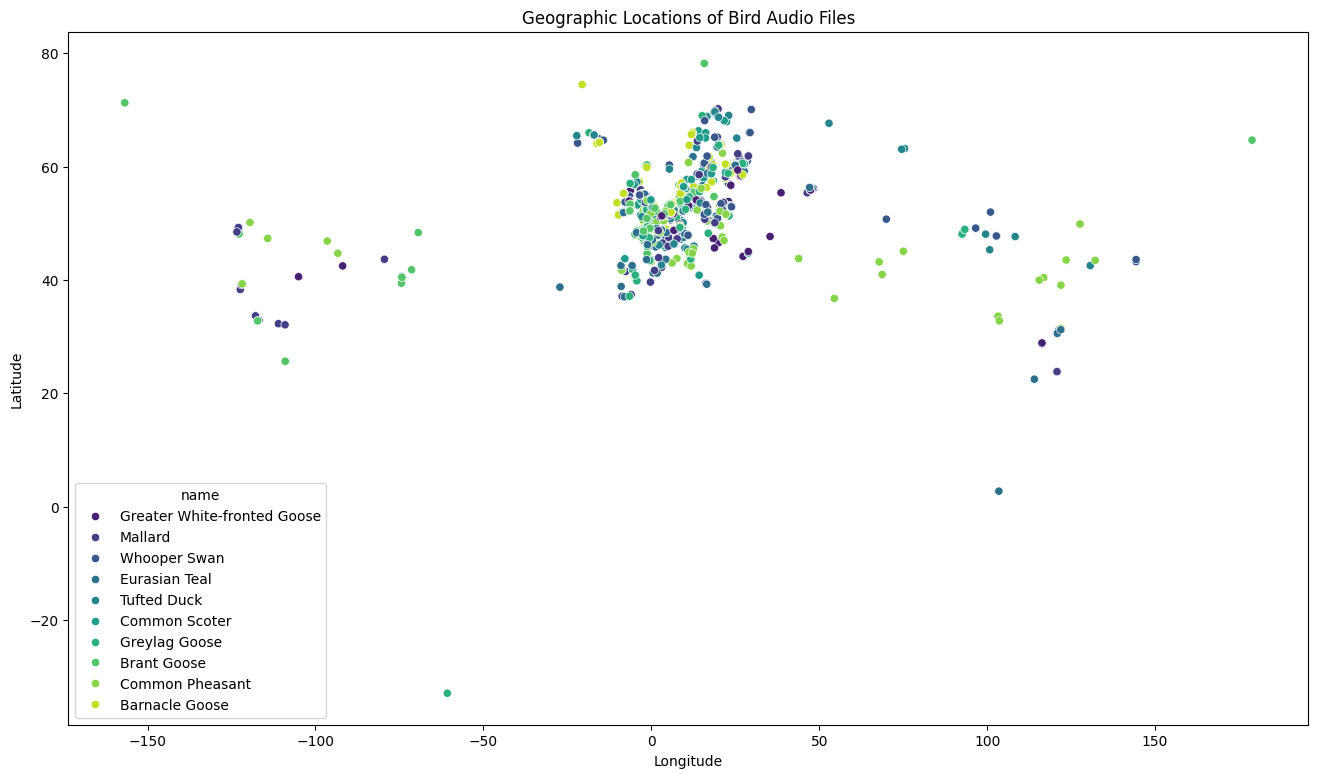

In [95]:
plt.figure(figsize=(16,9))

# Plot latitude vs longitude
sns.scatterplot(x='lng', y='lat', hue='name', data=metadata, palette='viridis')

# Customize the plot
plt.title('Geographic Locations of Bird Audio Files')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


## Interactive Map
 ##

An interactive map is created using folium to display the locations of the audio files with markers indicating different species.

In [99]:
import folium

# Create a mapping of species to colors
species_colors = {
    'Greater White-fronted Goose': 'blue',
    'Mallard': 'green',
    'Whooper Swan': 'purple',
    'Eurasian Teal': 'orange',
    'Tufted Duck': 'pink',
    'Common Scoter': 'lightblue',
    'Greylag Goose': 'darkgreen',
    'Brant Goose': 'red',
    'Common Pheasant': 'yellow',
    'Barnacle Goose': 'brown'
}

# Drop NaN values
meta = metadata.dropna()

# Create a Folium map
m = folium.Map(location=[meta['lat'].mean(), meta['lng'].mean()], zoom_start=4)

# Add markers to the map
for _, row in meta.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=row['country'] + ': ' + row['name'],
        icon=folium.Icon(color=species_colors.get(row['name'], 'gray'))  # Default to gray if not found
    ).add_to(m)


C:\Users\vaibh\AppData\Local\Temp\ipykernel_8728\216648266.py:28: UserWarning: color argument of Icon should be one of: {'lightblue', 'lightgray', 'black', 'blue', 'darkpurple', 'green', 'white', 'gray', 'pink', 'darkblue', 'purple', 'orange', 'beige', 'darkred', 'darkgreen', 'lightred', 'cadetblue', 'lightgreen', 'red'}.
  icon=folium.Icon(color=species_colors.get(row['name'], 'gray'))  # Default to gray if not found


In [102]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


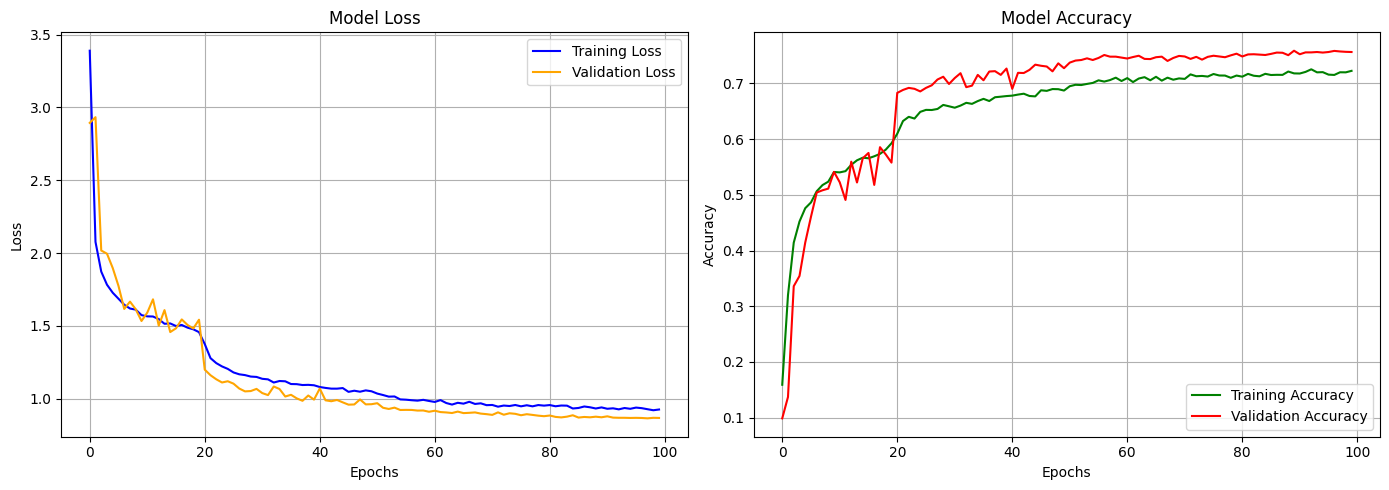

In [103]:
plot_training_history(history)